In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp

executable_path = sys.executable; scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath(osp.join(os.pardir, 'py')); ffmpeg_folder = r'C:\ffmpeg\bin'
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
import matplotlib.dates as mdates

Pretty printing has been turned OFF
======== Neo4j/5.24.2 ========
Utility libraries created in 6 seconds


In [2]:

# Cypher for rejection sentences
cypher_str = f'''
    // Get all the rejection sentences
    MATCH (fn:FileNames)
    WHERE (fn.rejection_email_text IS NOT NULL)
    RETURN fn.rejection_email_text AS rejection_email_text;'''

In [3]:

row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "You are not getting any rejection emails"
rejection_emails_df = DataFrame(row_objs_list)

In [5]:

# Tokenize the sentences
import re

tokenized_content = []
for content in rejection_emails_df.rejection_email_text:
    tokens = re.findall(r'\b\w+\b', content)
    tokenized_content.append(tokens)

# Convert the list of space-delimited strings into a single string per file
processed_documents = [' '.join(tokens) for tokens in tokenized_content]

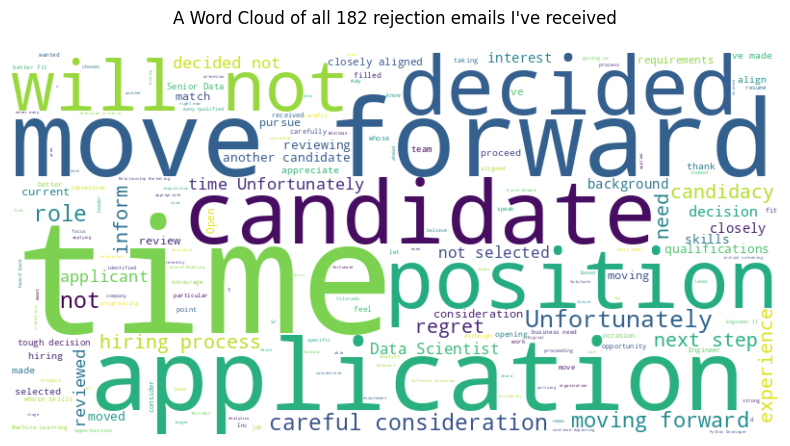

In [14]:

from wordcloud import WordCloud
import wordcloud

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=wordcloud.STOPWORDS.difference(set(['not']))).generate(' '.join(processed_documents))

# Display the Word Cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
title_str = f"A Word Cloud of all {rejection_emails_df.shape[0]} rejection emails I've received"
plt.title(title_str, pad=20, fontsize=12)  # Add title with some padding
plt.axis('off')
plt.show()


----

In [4]:

# Set the folder path
root_folder_path = '../builders'
!start %windir%\explorer.exe "{os.path.abspath(root_folder_path)}"

In [5]:

# Get the list of file names in the folder
file_type = '.ipynb'
file_names = []
black_list = ['.ipynb_checkpoints', '$Recycle.Bin', '.git']
folder_names = []
nu.delete_ipynb_checkpoint_folders(nu.github_folder)
directories_list = [name for name in os.listdir(nu.github_folder) if osp.isdir(osp.join(nu.github_folder, name))]
for folder_name in directories_list:
    folder_path = osp.join(nu.github_folder, folder_name)
    if all(map(lambda x: x not in folder_path, black_list)):
        notebook_names_list = [fn.replace(file_type, '') for fn in os.listdir(folder_path) if fn.endswith(file_type)]
        if notebook_names_list:
            file_names.extend(notebook_names_list)
            folder_names.extend(len(notebook_names_list) * [folder_path.split(os.sep)[-1]])

# Combine file names into a single string
text = ' '.join(file_names)

In [46]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Tokenize the content (split into space-delimited words)
# tokenized_content = [re.findall(r'\b\w+\b', content) for content in file_names]
# Read content from files and tokenize
tokenized_content = []
for file_name in file_names:
    with open(os.path.join(folder_path, file_name + file_type), 'r', encoding='utf-8') as file:
        content = file.read()
        tokens = re.findall(r'\b\w+\b', content)
        tokenized_content.append(tokens)

# Convert the list of space-delimited strings into a single string per file
processed_documents = [' '.join(tokens) for tokens in tokenized_content]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(processed_documents)

In [47]:

# Apply K-means clustering
new_sequence, string_to_integer_map = nu.convert_strings_to_integers(folder_names, alphabet_list=None)
num_clusters = len(string_to_integer_map)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

IndexError: index 21 is out of bounds for axis 0 with size 21

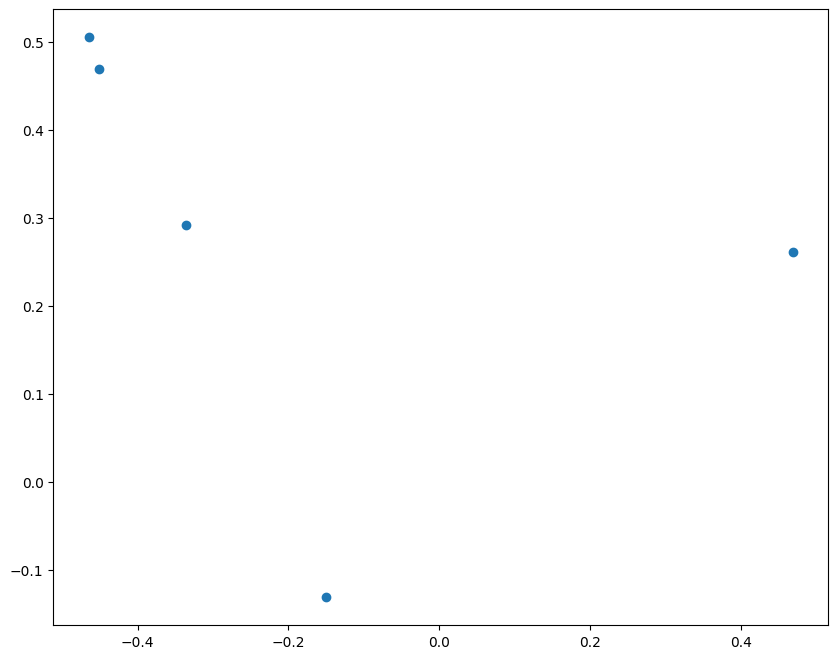

In [49]:

# Visualize the clusters in a scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
# color_cycler = nu.get_color_cycler(len(string_to_integer_map))
color_cycler = nu.get_color_cycler(len(clusters))
srs = pd.Series(clusters)
for folder_name, face_color_dict in zip(string_to_integer_map.keys(), color_cycler()):
    face_color = face_color_dict['color']
    mask_series = (srs == folder_name)
    i = srs[mask_series].index.values
    ax.scatter(X_pca[i, 0], X_pca[i, 1], c=face_color, label=folder_name)

# Set plot title and labels
ax.set_title('Document Cluster Analysis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Add a legend outside the box
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1), title='Folders')

plt.show()

In [62]:

folder_tuples_list = [(folder_name, file_name) for folder_name, file_name in zip(folder_names, file_names)]
for folder_tuple in sorted([(group, folder_name, file_name) for group, (folder_name, file_name) in zip(clusters, folder_tuples_list)]):
    print(*folder_tuple)

0 builders Build POS Conditional Random Field Elements
1 algorithms Build NP Graph from Examples
2 algorithms Build H-RQ Dictionary from Examples
2 algorithms Build O-RQ Dictionary from Examples
3 builders Set Educational Flags in NP Graph
4 builders Populate the HeaderTagSequence Table
5 builders Populate All Child Tag Sequences for FileNames
6 builders Get Parts-of-Speech Value Counts
7 algorithms Build NavigableParents SQL from Examples
8 builders Recreate the Header Pattern Dictionary
9 builders Populate Cypher Tables and Relationships
10 algorithms Build a Complete Part-of-Speech Dictionary
11 builders Ingest CSV and HTML Files
12 builders SQL Table Creation
13 builders Get Longest Path
14 builders Set Is Header Attribute
15 builders Build the Child Strings List Dictionary from Examples
16 builders Truncate Repeating NP IDs from NPS Table
17 builders Build O-TS Dictionary from Examples
18 builders Populate the NavigableParentSequence Table
19 builders Update NavigableParentSequenc

In [63]:

# Print file names grouped by cluster
file_names_by_cluster = {}
for cluster_id, file_name in zip(clusters, file_names):
    if cluster_id not in file_names_by_cluster:
        file_names_by_cluster[cluster_id] = []
    file_names_by_cluster[cluster_id].append(file_name)

# Print the results
for cluster_id, files in file_names_by_cluster.items():
    print(f'Cluster {cluster_id}:\n', files)
    print()

Cluster 10:
 ['Build a Complete Part-of-Speech Dictionary']

Cluster 2:
 ['Build H-RQ Dictionary from Examples', 'Build O-RQ Dictionary from Examples']

Cluster 7:
 ['Build NavigableParents SQL from Examples']

Cluster 1:
 ['Build NP Graph from Examples']

Cluster 17:
 ['Build O-TS Dictionary from Examples']

Cluster 0:
 ['Build POS Conditional Random Field Elements']

Cluster 15:
 ['Build the Child Strings List Dictionary from Examples']

Cluster 13:
 ['Get Longest Path']

Cluster 6:
 ['Get Parts-of-Speech Value Counts']

Cluster 11:
 ['Ingest CSV and HTML Files']

Cluster 5:
 ['Populate All Child Tag Sequences for FileNames']

Cluster 9:
 ['Populate Cypher Tables and Relationships']

Cluster 4:
 ['Populate the HeaderTagSequence Table']

Cluster 18:
 ['Populate the NavigableParentSequence Table']

Cluster 8:
 ['Recreate the Header Pattern Dictionary']

Cluster 3:
 ['Set Educational Flags in NP Graph']

Cluster 14:
 ['Set Is Header Attribute']

Cluster 12:
 ['SQL Table Creation']

Clus

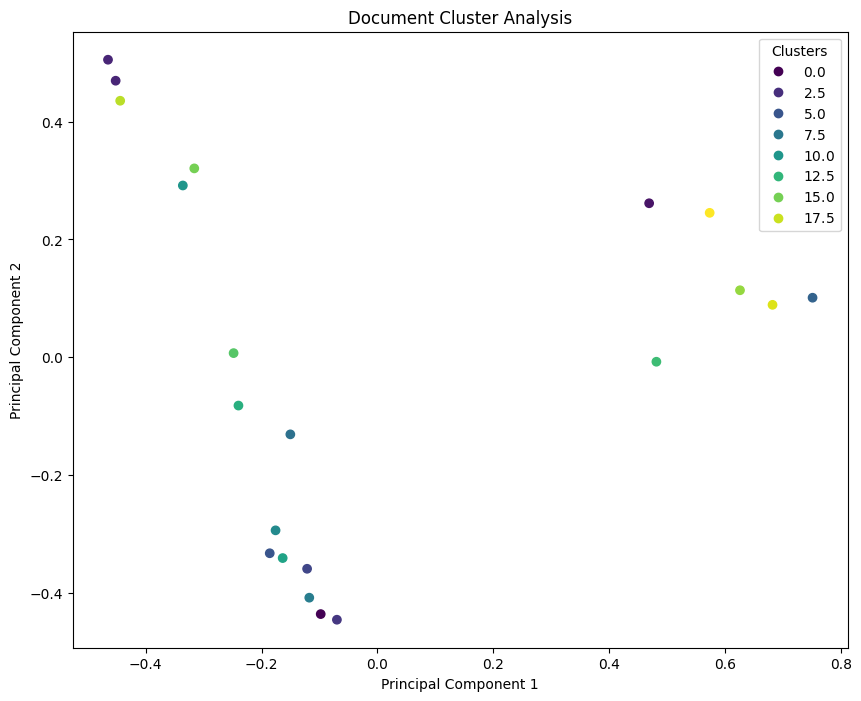

In [64]:

import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set the folder path
folder_path = '../builders'

# Get the list of file names in the folder
file_type = '.ipynb'
file_names = [fn.replace(file_type, '') for fn in os.listdir(folder_path) if fn.endswith(file_type)]

# Read content from files and tokenize
tokenized_content = []
for file_name in file_names:
    with open(os.path.join(folder_path, file_name + file_type), 'r', encoding='utf-8') as file:
        content = file.read()
        tokens = re.findall(r'\b\w+\b', content)
        tokenized_content.append(tokens)

# Convert the list of space-delimited strings into a single string per file
processed_documents = [' '.join(tokens) for tokens in tokenized_content]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(processed_documents)

# Apply K-means clustering
num_clusters = len(string_to_integer_map)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Visualize the clusters in a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Document Cluster Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

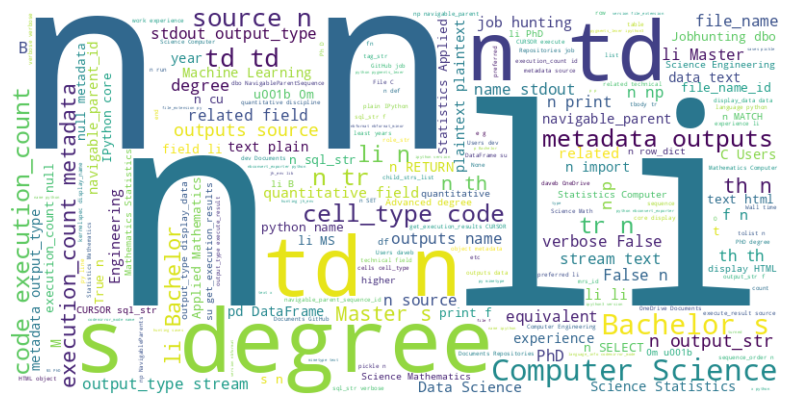

In [67]:

from wordcloud import WordCloud

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(processed_documents))

# Display the Word Cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()